<a href="https://colab.research.google.com/github/TheoLequy/HappinessHackers/blob/main/DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!rm /content/sample_data/HappinessHackers -r

In [37]:
# Clone the github repo with all the data
%cd /content

!git clone https://github.com/TheoLequy/HappinessHackers.git

# Change to this directory
%cd HappinessHackers/data

# List the files
!ls

/content
Cloning into 'HappinessHackers'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 142 (delta 74), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (142/142), 4.70 MiB | 3.97 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/HappinessHackers/data
average-monthly-surface-temperature.csv
average-precipitation-per-year.csv
covid-excess-deaths-daily-per-100k-economist.csv
death-rate-from-suicides-gho.csv
death-rate-in-armed-conflicts.csv
economic-inequality-gini-index.csv
gdp-pcap-ppp-const2017usd.csv
happiness-cantril-ladder.csv
human-development-index.csv
human-rights-index-vdem.csv
individual-liberties-and-equality-before-the-law-index.csv
learning-adjusted-years-of-school-lays.csv
life-expectancy.csv
share-deaths-air-pollution.csv
share-of-people-who-say-that-family-is-very-important-to-them-in-life.csv
share-of-population-urban.csv
share-of-population-wi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [38]:
import pandas as pd
import os
# Change to this directory

# Define the directory containing your files
data_directory = './'  # Change this to your data folder path

# List all CSV files in the directory
file_paths = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if filename.endswith('.csv')]

# Read all CSV files into DataFrames and store them in a list
dataframes = []
for file_path in file_paths:
  print(file_path)
  df = pd.read_csv(file_path)
  print(df.columns)

./gdp-pcap-ppp-const2017usd.csv
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', 'Unnamed: 68'],
      dtype='object')
./share-of-population-urban.csv
Index(['Entity', 'Code', 'Year', 'urbanization'], dtype='object')
./ti-corruption-perception-index.csv
Index(['Entity', 'Code', 'Year', 'corruption'], dtype='object')
./share-of-population-with-severe-food-insecurity.csv
Index(['Entity', 'Code', 'Year', '

In [ ]:
import pandas as pd
from functools import reduce

def load_allowed_countries(file_path):
    try:
        df = pd.read_csv(file_path)
        df.columns = [col.strip().lower() for col in df.columns]
        allowed_countries = df[df['year'] == 2018]['entity'].unique()
        return set(allowed_countries)
    except Exception as e:
        print(f"Failed to load allowed countries from {file_path}: {e}")
        return set()

def process_csv(file_path):
    try:
        if file_path == "./gdp-pcap-ppp-const2017usd.csv":
          df = pd.read_csv(file_path, skiprows=4)
          df = df.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 68'])
          id_cols = ["Country Name", "Country Code"]
          df = pd.melt(df, id_vars=id_cols, var_name='year', value_name='GDPPC')
          df = df.rename(columns={"Country Name": "entity", "Country Code": "code"})
        else:
          df = pd.read_csv(file_path)

        if file_path == "./average-monthly-surface-temperature.csv":
          df.columns = ['entity', 'code', 'year', 'date', 'monthly temp', 'yearly temp']
          df = df.drop(columns=['date', 'monthly temp'])
          df = df.drop_duplicates(subset=['entity', 'code', 'year'])

        # Standardize column names
        df.columns = [col.strip().lower() for col in df.columns]

        # Check if required columns are present
        required_columns = {'entity', 'code', 'year'}
        if not required_columns.issubset(set(df.columns)):
          print(f"Skipping {file_path} as it lacks one or more required columns.")
          return None

        # convert years to ints
        df["year"] = df["year"].astype(int)

        # Filter data for the year 2018
        df = df[df['year'] == 2018]
        if df.empty:
            print(f"Warning: No data for 2018 in {file_path}.")
            return None

        df = df[df['entity'].isin(allowed_countries)]
        # Select relevant columns, focusing on essentials and avoiding duplication of 'entity'
        df = df[['entity'] + [col for col in df.columns if col not in {'year', 'entity', 'code'}]]

        # Group by 'entity' and average the values if there are duplicates
        if df.duplicated('entity').any():
            df = df.groupby('entity').mean().reset_index()

        print(f"Processed {file_path}.")
        return df

    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None

def merge_dataframes(dataframes):
    # Merge all DataFrames on 'entity'
    if dataframes:
        base_df = dataframes[0]
        for df in dataframes[1:]:
            base_df = pd.merge(base_df, df, on='entity', how='outer')
        return base_df
    else:
        return pd.DataFrame()


# Load the allowed countries from a specific dataset
happiness_file_path = './happiness-cantril-ladder.csv'
allowed_countries = load_allowed_countries(happiness_file_path)


# Process each CSV file and remove None entries from the list
processed_dataframes = [df for df in [process_csv(f) for f in file_paths] if df is not None]

for processed_dataframe in processed_dataframes:
  print(len(processed_dataframe), processed_dataframe.columns)

# Merge all dataframes
all_data = merge_dataframes(processed_dataframes)

if not all_data.empty:
    # rename the columns
    # all_data.columns = ['entity', 'food_insec', 'precipitation', 'indiv_free', 'happiness', 'gini', 'hdi', 'gdp_pc', 'corruption', 'air_deaths', 'life_expectancy', 'temperature', 'urbanization', 'hri', 'suicides', 'taxes', 'schooling']

    # Save the result into a new CSV file
    output_filename = 'final_dataset_2018.csv'
    all_data.to_csv(output_filename, index=False)  # Don't write row indices
    print("Data processing and merging complete.")
else:
    print("No data to process.")


Processed ./gdp-pcap-ppp-const2017usd.csv.
Processed ./share-of-population-urban.csv.
Processed ./ti-corruption-perception-index.csv.
Processed ./share-of-population-with-severe-food-insecurity.csv.
Processed ./tax-revenues-as-a-share-of-gdp-unu-wider.csv.
Processed ./individual-liberties-and-equality-before-the-law-index.csv.
Processed ./learning-adjusted-years-of-school-lays.csv.
Processed ./life-expectancy.csv.
Processed ./average-monthly-surface-temperature.csv.
Processed ./human-rights-index-vdem.csv.
Processed ./death-rate-from-suicides-gho.csv.
Processed ./happiness-cantril-ladder.csv.
Skipping ./covid-excess-deaths-daily-per-100k-economist.csv as it lacks one or more required columns.
Processed ./human-development-index.csv.
Processed ./average-precipitation-per-year.csv.
Skipping ./final_dataset.csv as it lacks one or more required columns.
Processed ./share-deaths-air-pollution.csv.
Processed ./economic-inequality-gini-index.csv.
Skipping ./final_dataset_2018.csv as it lacks 

In [ ]:
df = pd.read_csv('final_dataset_2018.csv')
# df.columns = ['entity', 'food_insec', 'precipitation', 'individual_liberties', 'happiness', 'gini', 'hdi', 'gdp_pc', 'corruption', 'air_deaths', 'life_expectancy', 'temperature', 'urbanization', 'individual_liberties', 'suicides', 'taxes', 'schooling']
df.columns

Index(['entity', 'gdppc', 'urban population (% of total population)',
       'corruption perception index - transparency international (2018)',
       'prevalence of severe food insecurity in the total population (percent) (3-year average) | 00210401 || value | 006121 || percent',
       'taxes including social contributions (as a share of gdp)',
       'indiv_libs_vdem_owid', 'learning-adjusted years of school',
       'period life expectancy at birth - sex: all - age: 0', 'yearly temp',
       'civ_libs_vdem_owid', 'age-standardized suicide rate - sex: both sexes',
       'cantril ladder score', 'human development index',
       'average precipitation in depth (mm per year)',
       'share of total deaths that are from all causes attributed to air pollution, in both sexes aged age-standardized',
       'gini coefficient'],
      dtype='object')

In [47]:
# for multiple years

# Load the base data set
happiness_file_path = './happiness-cantril-ladder.csv'
data = pd.read_csv('./happiness-cantril-ladder.csv')
data = data.drop(columns='Entity')
data.columns = ['code', 'year', 'happiness']

data_directory = './'
file_paths = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if filename.endswith('.csv')]
file_paths.remove(happiness_file_path)
# file_paths.remove("./final_dataset_2018.csv")
# file_paths.remove("./final_dataset.csv")

for file_path in file_paths:
    try:
        if file_path == "./gdp-pcap-ppp-const2017usd.csv":
          df = pd.read_csv(file_path, skiprows=4)
          df = df.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 68'])
          id_cols = ["Country Name", "Country Code"]
          df = pd.melt(df, id_vars=id_cols, var_name='year', value_name='GDPPC')
          df = df.rename(columns={"Country Name": "entity", "Country Code": "code"})
        else:
          df = pd.read_csv(file_path)

        if file_path == "./share-of-people-who-say-that-family-is-very-important-to-them-in-life.csv":
          df = df.drop(columns='Continent')

        if file_path == "./covid-excess-deaths-daily-per-100k-economist.csv":
          df['Day'] = pd.to_datetime(df['Day']).dt.year
          df = df.rename(columns={'Day': 'year'})
          df = df.drop(columns=['estimated_daily_excess_deaths_ci_95_top_per_100k', 'estimated_daily_excess_deaths_ci_95_bot_per_100k'])


        if file_path == "./average-monthly-surface-temperature.csv":
          df.columns = ['entity', 'code', 'year', 'date', 'monthly temp', 'yearly temp']
          df = df.drop(columns=['date', 'monthly temp'])
          df = df.drop_duplicates(subset=['entity', 'code', 'year'])

        # Standardize column names
        df.columns = [col.strip().lower() for col in df.columns]

        # Check if required columns are present
        required_columns = {'code', 'year'}
        if not required_columns.issubset(set(df.columns)):
          print(f"Skipping {file_path} as it lacks one or more required columns.")
          continue

        # convert years to ints
        df["year"] = df["year"].astype(int)

        if 'entity' in df.columns:
          df = df.drop(columns='entity')

        # Group by 'entity' and average the values if there are duplicates
        if df.duplicated(subset=['code', 'year']).any():
            df = df.groupby(['code', 'year']).mean().reset_index()

        data = pd.merge(data, df, on=['code', 'year'], how='left')

        print(f"Processed {file_path}: {len(df.columns)}, {df.columns}")

    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        continue


data.head()

if not data.empty:
    """
    # rename the columns
    #data.columns = ['code', 'year', 'happiness', 'food_insec', 'precipitation',
    #                'indiv_free', 'gini', 'hdi', 'gdp_pc', 'family', 'corruption',
    #                'air_deaths', 'life_expectancy', 'temperature', 'urbanization',
    #                'covid', 'hri', 'suicides', 'taxes', 'schooling']
    data.columns = ['code', 'year', 'happiness', 'gdp_pc', 'urbanization',
                    'corruption', 'food_insec', 'taxes', 'indiv_free', 'schooling',
                    'life_expectancy', 'temperature', 'hri',
                    'suicides', 'family', 'covid',
                    'hdi', 'precipitation', 'air_deaths', 'gini']


    ['code' 'year' 'happiness' 'gdppc'
    'urban population (% of total population)'
    'corruption perception index - transparency international (2018)'
    'prevalence of severe food insecurity in the total population (percent) (3-year average) | 00210401 || value | 006121 || percent'
    'taxes including social contributions (as a share of gdp)'
    'indiv_libs_vdem_owid'
    'learning-adjusted years of school'
    'period life expectancy at birth - sex: all - age: 0'
    'yearly temp'
    'civ_libs_vdem_owid'
    'age-standardized suicide rate - sex: both sexes'
    'very important in life: family'
    'estimated_daily_excess_deaths_per_100k'
    'human development index'
    'average precipitation in depth (mm per year)'
    'share of total deaths that are from all causes attributed to air pollution, in both sexes aged age-standardized'
    'gini coefficient']
    """
    # Save the result into a new CSV file
    output_filename = '../final_dataset_raw.csv'
    data.to_csv(output_filename, index=False)

    # Group by 'code' and calculate the average for other columns
    data['covid'] = data['covid'].fillna(0)
    country_avg = data.groupby('code').transform(lambda x: x.fillna(round(x.mean(),3)))
    # Fill missing values in the original DataFrame with the calculated averages
    data_filled = data.combine_first(country_avg)

    # reorder the columns
    data_filled = data_filled[data.columns]
    # Save the result into a new CSV file
    output_filename = '../final_dataset_filled.csv'
    data_filled.to_csv(output_filename, index=False)
    print("Data processing and merging complete.")
else:
    print("No data to process.")


Failed to process ./gdp-pcap-ppp-const2017usd.csv: "['Indicator Name', 'Indicator Code'] not found in axis"
Processed ./share-of-population-urban.csv: 3, Index(['code', 'year', 'urbanization'], dtype='object')
Processed ./ti-corruption-perception-index.csv: 3, Index(['code', 'year', 'corruption'], dtype='object')
Processed ./share-of-population-with-severe-food-insecurity.csv: 3, Index(['code', 'year', 'food_insec'], dtype='object')
Processed ./tax-revenues-as-a-share-of-gdp-unu-wider.csv: 3, Index(['code', 'year', 'tax'], dtype='object')
Processed ./individual-liberties-and-equality-before-the-law-index.csv: 3, Index(['code', 'year', 'indiv_libs'], dtype='object')
Processed ./learning-adjusted-years-of-school-lays.csv: 3, Index(['code', 'year', 'school'], dtype='object')
Processed ./life-expectancy.csv: 3, Index(['code', 'year', 'life_expect'], dtype='object')
Processed ./average-monthly-surface-temperature.csv: 3, Index(['code', 'year', 'yearly temp'], dtype='object')
Processed ./hum

In [ ]:
print(data.columns.values)

['code' 'year' 'happiness' 'gdppc_x'
 'urban population (% of total population)_x'
 'corruption perception index - transparency international (2018)_x'
 'prevalence of severe food insecurity in the total population (percent) (3-year average) | 00210401 || value | 006121 || percent_x'
 'taxes including social contributions (as a share of gdp)_x'
 'indiv_libs_vdem_owid_x' 'learning-adjusted years of school_x'
 'period life expectancy at birth - sex: all - age: 0_x' 'yearly temp_x'
 'civ_libs_vdem_owid_x'
 'age-standardized suicide rate - sex: both sexes_x'
 'very important in life: family_x'
 'estimated_daily_excess_deaths_per_100k_x' 'human development index_x'
 'average precipitation in depth (mm per year)_x' 'happiness_x' 'gdppc_y'
 'urban population (% of total population)_y'
 'corruption perception index - transparency international (2018)_y'
 'prevalence of severe food insecurity in the total population (percent) (3-year average) | 00210401 || value | 006121 || percent_y'
 'taxes i

In [ ]:
print(data.columns.values)
print(data.shape)

['code' 'year' 'happiness_x' 'gdppc'
 'urban population (% of total population)'
 'corruption perception index - transparency international (2018)'
 'prevalence of severe food insecurity in the total population (percent) (3-year average) | 00210401 || value | 006121 || percent'
 'taxes including social contributions (as a share of gdp)'
 'indiv_libs_vdem_owid' 'learning-adjusted years of school'
 'period life expectancy at birth - sex: all - age: 0' 'yearly temp'
 'civ_libs_vdem_owid' 'age-standardized suicide rate - sex: both sexes'
 'very important in life: family' 'estimated_daily_excess_deaths_per_100k'
 'human development index' 'average precipitation in depth (mm per year)'
 'happiness_y' 'gdp_pc' 'urbanization' 'corruption' 'food_insec' 'taxes'
 'indiv_free' 'schooling' 'life_expectancy' 'temperature' 'hri' 'suicides'
 'family' 'covid' 'hdi' 'precipitation' 'air_deaths' 'gini'
 'share of total deaths that are from all causes attributed to air pollution, in both sexes aged age-st

In [ ]:
from time import perf_counter
file_path = '/content/happiness-hacking/ourworldindata/covid-excess-deaths-daily-per-100k-economist.csv'

df = pd.read_csv(file_path)

time1 = perf_counter()
df['Day'] = pd.to_datetime(df['Day']).dt.year
time2 = perf_counter()

df = df.rename(columns={'Day': 'year'})
df = df.drop(columns = ['estimated_daily_excess_deaths_ci_95_top_per_100k', 'estimated_daily_excess_deaths_ci_95_bot_per_100k'])

average_temps_df = df.groupby(['Entity', 'year'])['estimated_daily_excess_deaths_per_100k'].mean().reset_index()

print(average_temps_df)
time2-time1

           Entity  year  estimated_daily_excess_deaths_per_100k
0     Afghanistan  2020                                0.178229
1     Afghanistan  2021                                0.282519
2     Afghanistan  2022                                0.250676
3     Afghanistan  2023                                0.156752
4     Afghanistan  2024                                0.129409
...           ...   ...                                     ...
1180     Zimbabwe  2020                                0.201667
1181     Zimbabwe  2021                                0.635533
1182     Zimbabwe  2022                                0.338414
1183     Zimbabwe  2023                                0.108688
1184     Zimbabwe  2024                               -0.004235

[1185 rows x 3 columns]


0.012259150999852864

In [ ]:
# import numpy as np
# df = pd.DataFrame({'code': ['a','a','a','b','b','b','c'], 'val': [1,2,np.nan, np.nan, np.nan, np.nan, 3]})
# country_avg = df.groupby('code').transform(lambda x: x.fillna(x.mean()))
# # Fill missing values in the original DataFrame with the calculated averages
# data_filled = data.combine_first(country_avg)

In [ ]:
%cd /
%cd content
%cp 'happiness-hacking/ourworldindata/final_dataset.csv' 'final_dataset.csv'

/
/content
death-rate-in-armed-conflicts.csv  happiness-hacking  sample_data


In [ ]:
file_path = 'death-rate-in-armed-conflicts.csv'

df_death = pd.read_csv(file_path)
df_ds = pd.read_csv("final_dataset.csv")
df_death.rename(columns={'Death rate in ongoing conflicts in a country (best estimate) - Conflict type: all': 'deaths'}, inplace=True)

df_death.set_index(['Code', 'Year'], inplace=True)
df_ds.set_index(['code', 'year'], inplace=True)

df_death_reordered = df_death.reindex(df_ds.index)

df_ds['death_rate'] = df_death_reordered['deaths']

df_ds.to_csv('final_dataset.csv', index=True)


FileNotFoundError: [Errno 2] No such file or directory: 'death-rate-in-armed-conflicts.csv'

<BarContainer object of 18 artists>

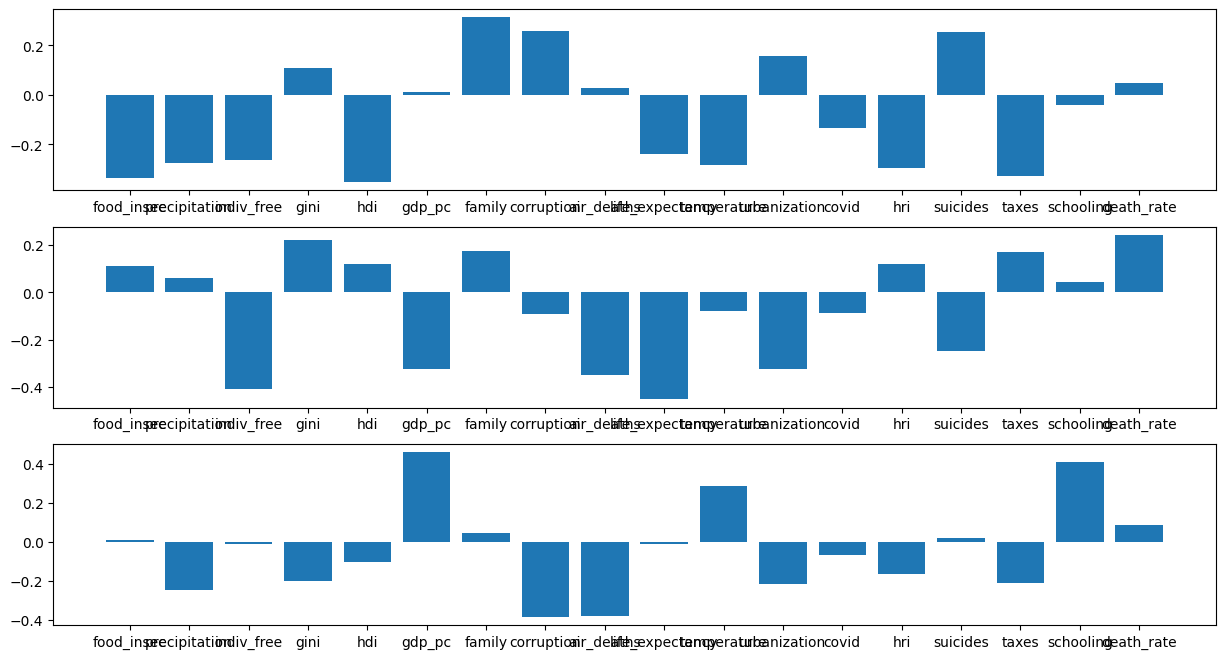

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load the data from CSV
df = pd.read_csv('final_dataset.csv')  # Replace 'your_data.csv' with your actual CSV file path

# Extract labels from the DataFrame
labels = df['code']  # Replace 'label_column' with the name of your label column

# Exclude label column and any other non-feature columns from PCA
X = df.drop(columns=['code','happiness','year'])  # Replace 'non_feature_column1', 'non_feature_column2', etc. with any other non-feature columns


data_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values using the mean
    ('scaler', StandardScaler())  # Scale data
])
X = data_preprocessing.fit_transform(X)




# Apply PCA
pca = PCA()  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=X_pca)

principal_components = pca.components_
principal_variance = pca.explained_variance_

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
xx = xx = df.drop(columns=['code','happiness','year']).columns.values
#plt.bar(np.linspace(0,len(principal_variance),len(principal_variance)),principal_variance)
ax1.bar(xx , principal_components[0])
#plt.bar(np.linspace(0,len(principal_variance),len(principal_variance)),principal_variance)
ax1.bar(xx , principal_components[0])
ax2.bar(xx , principal_components[1])
ax3.bar(xx , principal_components[2])